# COMP5318 - Machine Learning and Data Mining: Assignment 2
<div style="text-align: right"> Due: Wed 18 Nov 2020 11:59PM </div>
<div style="text-align: right"> Group 97 </div>

## Other Algorithm: Random Forest, Support Vector Machine

### Imports

In [15]:
import tensorflow as tf 
from keras.datasets import cifar100
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from skimage import exposure
from skimage import feature

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout
from keras.datasets import cifar100

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Helper Methods

#### Importing Data

In [16]:
def import_data() -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):
    return tf.keras.datasets.cifar100.load_data(label_mode="coarse")

def load_in_dataset_and_preprocess_validation_testing(explained_variance):
    (training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))
    
    # reshape the data 
    training_data = training_data.reshape(50000, 3072)
    testing_data = testing_data.reshape(10000, 3072)
    
    concatenated_training = concatenate_data(training_data, training_labels)
    
    training_set, validation_set = split_into_validation_training(concatenated_training)
    
    training_data = training_set[:, :-1]
    training_labels = np.squeeze(training_set[:, -1])
    
    validation_data = validation_set[:, :-1]
    validation_labels = np.squeeze(validation_set[:, -1])
    
    training_data = training_data.astype('float32')
    validation_data = validation_data.astype('float32')

    # Centre data
    training_data, validation_data = centre_data(training_data, validation_data)

    # Apply PCA
    training_data, validation_data = PCA(explained_variance, training_data, validation_data)
    
    # Normalization of pixel values (to [0-1] range)
    training_data = training_data / 255
    validation_data = validation_data / 255
    
    return training_data, training_labels, validation_data, validation_labels


In [17]:
## split data into training and validation set with 30:70 split 
def split_into_validation_training(training_matrix):
    
    import random
    random.shuffle(training_matrix)

    training_set = training_matrix[:int(len(training_matrix)*0.7)]
    validation_set = training_matrix[int(len(training_matrix)*0.7):]
    
    return training_set, validation_set

In [18]:
## apply PCA 
def PCA(variance_target, training_data, testing_data):

    U, sigma, Vt = np.linalg.svd(training_data, full_matrices=False)
    
    sum_square_singular = np.sum(sigma**2)
    
    ratios = sigma**2/sum_square_singular
    
    n_components = 0
    explained_variance = 0
    
    # determine how many principle components must be retained to maintain the target level of explained variance
    for i in range(len(ratios)):
        if explained_variance >= variance_target:
            break
        else: 
            n_components += 1
            explained_variance += ratios[i]
    
    return training_data.dot(Vt.T[:, :n_components]), testing_data.dot(Vt.T[:, :n_components])


In [19]:
## helper function for concatenating labels onto their corresponding data points
def concatenate_data(training_data, training_labels):
    return np.column_stack((training_data, training_labels))

In [20]:
## centre the data
def centre_data(train, test):
    
    # calculate the means for each attribute of the training data
    column_means = np.mean(train, axis=0) 
    
    # centre training data by subtracting training data attribute means
    for i in range(len(train)):
        train[i] = train[i] - column_means
    
    # centre testing data by subtracting training data attribute means
    for x in range(len(test)):
        test[x] = test[x] - column_means
        
    return train, test

#### Converting Images to Grayscale

In [21]:
def convert_to_grayscale(train, test):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray_train = np.dot(train[:][...,:3], rgb_weights)
    gray_test = np.dot(test[:][...,:3], rgb_weights)
    return gray_train.astype(int), gray_test.astype(int)

#### Increasing Contrast

In [44]:
def increase_image_contrast(image, strength):
    p_low, p_high = np.percentile(image, (strength, 100 - strength))
    return (exposure.rescale_intensity(image, in_range=(p_low, p_high))).astype(int)

def increase_all_contrast(train, test, strength=10):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = increase_image_contrast(train[i], strength)
    for i in range(len(test)):
        new_test[i] = increase_image_contrast(test[i], strength)
    return new_train, new_test

#### Histogram Equalization

In [ ]:
def equalize_hist(image):
    return (exposure.equalize_hist(image) * 255).astype(int)

def equalize_hist_all(train, test):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = equalize_hist(train[i])
    for i in range(len(test)):
        new_test[i] = equalize_hist(test[i])
    return new_train, new_test

#### Adaptive Histogram Equalization

In [ ]:
def equalize_adapthist(image, clip_lim):
    return (exposure.equalize_adapthist(image, clip_limit=clip_lim) * 255).astype(int)

def equalize_adapthist_all(train, test, clip_limit=0.03):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = equalize_adapthist(train[i], clip_limit)
    for i in range(len(test)):
        new_test[i] = equalize_adapthist(test[i], clip_limit)
    return new_train, new_test

#### Canny Edge Detection

In [ ]:
def canny_edge_filter_all(train, test, sig=1):
    if (len(train.shape) > 3):
        train, test = convert_to_grayscale(train, test)
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = feature.canny(train[i].astype(float), sigma=sig)
    for i in range(len(test)):
        new_test[i] = feature.canny(test[i].astype(float), sigma=sig)
    return new_train, new_test

#### Flattening Images and Labels

In [ ]:
def flatten_data(x_train, y_train, x_test, y_test):
    new_image_shape = 1
    for dim in range(1, len(x_train.shape)):
        new_image_shape *= x_train.shape[dim]
        
    flat_x_train = x_train.reshape((x_train.shape[0], new_image_shape))
    flat_y_train = np.ravel(y_train)
    
    flat_x_test = x_test.reshape((x_test.shape[0], new_image_shape))
    flat_y_test = np.ravel(y_test)
    return flat_x_train, flat_y_train, flat_x_test, flat_y_test

### Algorithm 2: Multi-Layer Perceptron

#### Preprocessing:
- Flatten data
- Centre Data
- Run PCA

#### Parameters:
- `first activation function = 'relu'`
- `second activation function = 'softmax'`
- `number of hidden units = 256`
- `learning rate = 0.001`
- `optimizer = 'Adam'`
- `decay = 1e-6`
- `momentum = 0.9`
- `epochs = 50`
- `loss function = 'sparse_categorical_crossentropy'`

In [22]:
def load_in_dataset_and_preprocess_mlp(explained_variance):
    (training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))
    
    # reshape the data 
    training_data = training_data.reshape(50000, 3072)
    testing_data = testing_data.reshape(10000, 3072)
    
    training_labels = np.squeeze(training_labels)
    testing_labels = np.squeeze(testing_labels)
    
    training_data = training_data.astype('float32')
    testing_data = testing_data.astype('float32')

    # Centre data
    training_data, testing_data = centre_data(training_data, testing_data)

    # Apply PCA
    training_data, testing_data = PCA(explained_variance, training_data, testing_data)
    
    # Normalization of pixel values (to [0-1] range)
    training_data = training_data / 255
    testing_data = testing_data / 255
    
    return training_data, training_labels, testing_data, testing_labels

In [23]:
def run_MLP_model(training_data, training_labels, testing_data, testing_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay_level, momentum, epochs, loss_function):

    model = Sequential()

    model.add(Dense(num_hidden_units, activation=first_activation_function, input_dim=training_data.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(num_hidden_units, activation=first_activation_function))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation=second_activation_function))

    if (optimiser == 'SGD'):
        op = SGD(lr=learning_rate, decay=decay_level, momentum=momentum, nesterov=True)
    else:
        op = Adam(lr=learning_rate, decay=decay_level)

    model.compile(optimizer=op,
                  loss=loss_function,
                  metrics=['accuracy'])

    history = model.fit(training_data, training_labels, epochs=epochs, batch_size=32, verbose=0, validation_split=0.2)

    score = model.evaluate(testing_data, testing_labels, batch_size=128, verbose=0)
    
    return score[1], model

training_data, training_labels, testing_data, testing_labels = load_in_dataset_and_preprocess_mlp(0.9)
score, model = run_MLP_model(training_data, training_labels, testing_data, testing_labels, 'relu', 'softmax', 256, 0.001, 'Adam', 1e-6, 0.9, 50, 'sparse_categorical_crossentropy')
print(score)


0.3630000054836273


### Confusion Matrix

In [32]:
conf_matrix = np.zeros((20, 20))
predictions = model.predict(testing_data)
correct_predictions = 0
print(predictions.shape)

for index, value in enumerate(predictions):
    prediction_class = np.argmax(value)
    conf_matrix[testing_labels[index]][prediction_class] += 1
    if testing_labels[index] == prediction_class:
        correct_predictions += 1

print("Accuracy: {}".format(correct_predictions / float(len(testing_data))))
print("Confusion Matrix:")
print(conf_matrix)

(10000, 20)
Accuracy: 0.363
Confusion Matrix:
[[206.  21.   2.   1.   1.   8.  14.  28.  67.  15.   8.  15.  36.   8.
   17.  15.   9.   1.  16.  12.]
 [ 79. 128.  25.   2.  18.  13.  15.  16.  44.  17.  10.   3.  29.   5.
   39.  29.   7.   3.  11.   7.]
 [  4.   4. 289.   2.  60.   4.   8.  28.  32.   4.   1.   4.   5.   1.
   32.   6.   5.   5.   4.   2.]
 [ 13.   5.  12. 141.  35.  43.  38.  19.  54.  10.   2.   7.  12.   4.
   56.  10.   7.   5.  14.  13.]
 [  5.   8.  66.   2. 228.   4.  16.  45.  55.   2.   1.   8.   4.   3.
   32.   5.   3.   5.   5.   3.]
 [ 22.  13.  14.  33.  12. 119.  37.  15.  53.  12.   6.   7.  18.   3.
   53.  12.  11.   6.  38.  16.]
 [ 11.   4.   5.   7.  26.  18. 189.  13.  68.  16.   9.   5.   9.   4.
   62.   5.   5.   8.  26.  10.]
 [ 26.   9.  17.   7.  13.   3.  11. 242.  62.   5.   2.  14.  18.   5.
   26.  14.  11.   4.   5.   6.]
 [ 32.   1.   3.   2.   4.   7.  15.  25. 256.   6.   3.  29.  40.   5.
   37.   8.  10.   5.   7.   5.]
 [ 21.   

###Precision and Recall

In [28]:
false_positive = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
false_negative = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
true_positive = np.diag(conf_matrix)
true_negative = conf_matrix.sum() - (false_positive + false_negative + true_positive)

# Sensitivity, hit rate, recall, or true positive rate
recall = true_positive/(true_positive+false_negative)

# Precision or positive predictive valuep
precision = true_positive/(true_positive+false_positive)

# Overall accuracy
#ACC = (TP+TN)/(TP+FP+FN+TN)

print(recall)
print(precision)

[0.412 0.256 0.578 0.282 0.456 0.238 0.378 0.484 0.512 0.556 0.564 0.226
 0.254 0.066 0.518 0.144 0.092 0.624 0.3   0.32 ]
[0.29811867 0.50592885 0.58032129 0.564      0.46625767 0.39016393
 0.36627907 0.33988764 0.16452442 0.41554559 0.64090909 0.33933934
 0.23605948 0.30841121 0.29232506 0.26181818 0.25       0.65408805
 0.33407572 0.43010753]


### Algorithm 3: Support Vector Machine

#### Preprocessing:
- Flatten data
- Centre Data
- Run PCA

#### Parameters:
- `learning_rate = 0.00000001`
- `regularisation_param = 1000`
- `iterations = 20000`
- `batch_size = 200`
- `num_classes = 20`

In [38]:
class SVM:

    training_data=[]
    testing_data=[]

    def __init__(self, training_data, testing_data):
        self.training_data= training_data
        self.testing_data= testing_data

    def __len__(self, data):
        return len(data)

    def calculate_linear_output(self, data, weights):
        return np.dot(data, weights)

    def calculate_distance(self, X, w):
        return  y * (np.dot(X, w)) - 1

    # calculate gradient, use L2 regularisation 
    def calculate_gradient(self, weights, regularisation_param, training_data, training_labels, num_classes):
        
        num_training_samples, num_training_features = training_data.shape
        
        gradient = np.zeros((num_training_features, num_classes))
        
        # w^Tx
        linear_output = self.calculate_linear_output(training_data, weights)

        linear_output_y_i = linear_output[np.arange(num_training_samples),training_labels]
        delta = linear_output - linear_output_y_i[:,np.newaxis] + 1
        
        ones_and_zeros = np.zeros(delta.shape)
        
        # With lagrange multiplier considered, if on the support vector: 𝛼 = 1, else 𝛼 = 0
        ones_and_zeros = np.where(delta > 0, 1, 0)
        
        # calculate the sum of each row 
        sum_of_each_row = np.sum(ones_and_zeros, axis=1)
        
        ones_and_zeros[np.arange(num_training_samples), training_labels] = - sum_of_each_row

        gradient = (1/num_training_samples) * np.dot((training_data.T), ones_and_zeros)
        
        # controls the influence of each individual support vector 
        gradient = gradient + (2* regularisation_param * weights)
        
        return gradient 

    # train model using stochastic gradient descent 
    def train_model(self, training_data, training_labels, weights, learning_rate, regularisation_param, iterations, batch_size, num_classes):
      
        num_training_samples = len(training_data)
        weights = weights

        for i in range(iterations):
        # create batch
            batch = np.random.choice(5000, batch_size) #change this to num_training_samples 
            gradient = self.calculate_gradient(weights, regularisation_param, training_data[batch], training_labels[batch], num_classes)
            weights = weights - learning_rate * gradient

        return weights

    # calculate accuracy of model 
    def calculate_accuracy (self, data, labels, weights):
        
        accuracy = 0
        prediction = np.zeros(len(data))

        #w^Tx
        linear_output= self.calculate_linear_output(data, weights)

        # returns the indices of the maximum values along an axis
        prediction = np.argmax(linear_output, axis=1)

        # count the number of predictions that are correct 
        total_correct_predictions = (prediction == labels).sum()
        num_data_points = len(data)
        accuracy = (total_correct_predictions/num_data_points)*100

        return accuracy, prediction

def preprocess_data(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(50000, 3072).astype('float32')
    x_test = x_test.reshape(10000, 3072).astype('float32')

    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)

    x_train = np.reshape(x_train, (len(x_train), -1))
    x_test = np.reshape(x_test, (len(x_test), -1))

    x_train, x_test = centre_data(x_train, x_test)
    x_train, x_test = PCA(0.9, x_train, x_test)
    
    return x_train, y_train, x_test, y_test

(x_train, y_train), (x_test, y_test) = import_data()

x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)

svm = SVM(x_train, x_test)
weights = np.ones((len(x_train[0]), np.max(y_train) + 1))
trained_weights = svm.train_model(x_train, y_train, weights, 0.00000001, 1000, 20000, 200, 20)


total_accuracy, predictions2 = svm.calculate_accuracy(x_test, y_test, trained_weights)
%time print('Accuracy: {}'.format(total_accuracy))

Accuracy: 22.25
CPU times: user 478 µs, sys: 21 µs, total: 499 µs
Wall time: 255 µs


### Confusion Matrix

In [43]:
conf_matrix = np.zeros((20, 20))
correct_predictions = 0
print(predictions2.shape)

for index, value in enumerate(predictions2):
    prediction_class = np.argmax(value)
    conf_matrix[y_test[index]][value] += 1
    if y_test[index] == value:
        correct_predictions += 1

print("Accuracy: {}".format(correct_predictions / float(len(testing_data))))
print("Confusion Matrix:")
print(conf_matrix)

(10000,)
Accuracy: 0.2225
Confusion Matrix:
[[155.  61.   6.  18.   9.  17.  13.  26.  10.  15.  28.  26.  32.   6.
   11.  12.  12.  12.  14.  17.]
 [ 73. 109.  25.  17.  48.  14.  11.  11.  11.  22.  26.  12.  19.   6.
   26.   9.  21.   9.  19.  12.]
 [  8.  12. 168.  14. 124.   6.  26.  21.   9.   4.  12.   9.   7.   7.
   43.   1.   6.  14.   5.   4.]
 [ 31.  13.  29.  91.  35.  43.  28.  23.  15.   8.  28.  20.  29.   6.
   22.  10.  26.  17.  18.   8.]
 [  6.   7.  82.  16. 244.   5.  18.  20.  10.   3.   3.  16.   8.   8.
   22.   4.   8.  12.   4.   4.]
 [ 44.  18.  19.  60.  20.  69.  40.  13.  13.  12.  23.  17.  17.   4.
   25.  11.  12.  11.  53.  19.]
 [ 18.  15.  34.  38.  65.  34.  89.  17.   8.   5.  18.  17.  15.  10.
   44.  10.  13.   9.  30.  11.]
 [ 27.  23.  14.  20.  62.  13.  21. 146.  12.   3.   4.  50.  34.   8.
    9.  13.  19.  10.   6.   6.]
 [ 30.  17.  23.  28.  48.  22.  25.  36.  38.   7.   7.  25.  78.  10.
   29.   9.  30.  18.  15.   5.]
 [ 30.  21.

###Precision and Recall

In [44]:
false_positive = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
false_negative = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
true_positive = np.diag(conf_matrix)
true_negative = conf_matrix.sum() - (false_positive + false_negative + true_positive)

# Sensitivity, hit rate, recall, or true positive rate
recall = true_positive/(true_positive+false_negative)

# Precision or positive predictive valuep
precision = true_positive/(true_positive+false_positive)

# Overall accuracy
#ACC = (TP+TN)/(TP+FP+FN+TN)

print(recall)
print(precision)

[0.31  0.218 0.336 0.182 0.488 0.138 0.178 0.292 0.076 0.238 0.322 0.138
 0.24  0.01  0.262 0.04  0.092 0.57  0.18  0.14 ]
[0.21059783 0.21499014 0.26624406 0.17533719 0.24897959 0.16666667
 0.17623762 0.25659051 0.13718412 0.25158562 0.26567657 0.14226804
 0.17518248 0.03676471 0.24904943 0.1025641  0.11764706 0.46416938
 0.20179372 0.2295082 ]


### Testing

#### Imports and Helpers

In [ ]:
import time
import csv

def nano_to_seconds(nanoseconds):
    """Converts nanoseconds to seconds rounded to the nearest 5 decimal places.
    
    Parameters
    ----------
    nanoseconds : int
        The nanoseconds to convert
    """

    return np.round((nanoseconds / 1e+9), 5)

#### Random Forest

In [ ]:
def test_random_forest_estimators():
    num_estimators = list(range(100, 1001, 100)) + [1250, 1500, 1750, 2000]
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_estimators.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Average Accuracy', 'Average Runtime'])
        max_features = 'log2'
        criterion = 'gini'
        bootstrap = False
        for n_estimators in num_estimators:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
            for i in range(2):
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, avg_accuracy, avg_runtime])
            print("Finished n_estimators: {}".format(n_estimators))
            
def test_random_forest_max_features():
    max_features_list = ['sqrt', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_features.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        criterion = 'gini'
        bootstrap = False
        for max_features in max_features_list:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            iterations = 1
            if max_features == "sqrt" or max_features == "log2":
                iterations = 5
            for i in range(iterations):
                x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, avg_accuracy, avg_runtime])
            print("Finished max_features: {}".format(max_features))
            
def test_random_forest_criterion():
    criterion_list = ['gini', 'entropy']
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_criterion.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        max_features = 'log2'
        bootstrap = False
        for criterion in criterion_list:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(5):
                x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, avg_accuracy, avg_runtime])
            print("Finished criterion: {}".format(criterion))
            
def test_random_forest_bootstrap():
    max_samples_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
    bootstrap_list = [False, True]
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_bootstrap.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Max Samples', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        criterion = 'gini'
        max_features = 'log2'
        max_samples = 1.0
        for bootstrap in bootstrap_list:
            if not bootstrap:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0
                for i in range(5):
                    x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                    model = RandomForestClassifier(
                                n_jobs=-1, 
                                verbose=0,
                                n_estimators=n_estimators,
                                bootstrap=bootstrap, 
                                max_features=max_features, 
                                criterion=criterion)
                    start_time = time.time_ns()
                    model.fit(x_train, y_train)
                    total_accuracy += model.score(x_test, y_test)
                    end_time = time.time_ns()
                    total_runtime += nano_to_seconds(end_time - start_time)
                    num_tests += 1
                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow([n_estimators, max_features, criterion, bootstrap, max_samples, avg_accuracy, avg_runtime])
                print("Finished bootstrap: {}".format(bootstrap))
            else:
                for item in max_samples_list:
                    max_samples = item
                    num_tests = 0
                    total_accuracy = 0
                    total_runtime = 0
                    for i in range(5):
                        x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                        model = RandomForestClassifier(
                                    n_jobs=-1, 
                                    verbose=0,
                                    n_estimators=n_estimators,
                                    bootstrap=bootstrap,
                                    max_samples=max_samples,
                                    max_features=max_features, 
                                    criterion=criterion)
                        start_time = time.time_ns()
                        model.fit(x_train, y_train)
                        total_accuracy += model.score(x_test, y_test)
                        end_time = time.time_ns()
                        total_runtime += nano_to_seconds(end_time - start_time)
                        num_tests += 1
                    avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                    avg_runtime = np.round(total_runtime / float(num_tests), 5)
                    result_writer.writerow([n_estimators, max_features, criterion, bootstrap, max_samples, avg_accuracy, avg_runtime])
                    print("Finished bootstrap - max_samples: {} - {}".format(bootstrap, max_samples))
                    
def test_random_forest_image_filter():
    techniques = ['none', 'grayscale', 'hist equalization', 'adaptive equalization', 'canny']
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_filter.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Technique', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        max_features = 'log2'
        bootstrap = False
        criterion = 'gini'
        for technique in techniques:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            x_train = np.copy(raw_x_train)
            y_train = np.copy(raw_y_train)
            x_test = np.copy(raw_x_test)
            y_test = np.copy(raw_y_test)
            if technique == 'grayscale':
                x_train, x_test = convert_to_grayscale(raw_x_train, raw_x_test)
            elif technique == 'hist equalization':
                x_train, x_test = equalize_hist_all(raw_x_train, raw_x_test)
            elif technique == 'adaptive equalization':
                x_train, x_test = equalize_adapthist_all(raw_x_train, raw_x_test)
            elif technique == 'canny':
                x_train, x_test = canny_edge_filter_all(raw_x_train, raw_x_test, 0)
            x_train, y_train, x_test, y_test = flatten_data(x_train, y_train, x_test, y_test)
            for i in range(5):
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, technique, avg_accuracy, avg_runtime])
            print("Finished technique: {}".format(technique))
            
def test_random_forest_contrast_stretching():
    stretch_factor = list(range(0, 46, 5))
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_contrast.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Contrast Strength', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        max_features = 'log2'
        bootstrap = False
        criterion = 'gini'
        for strength in stretch_factor:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            x_train, x_test = increase_all_contrast(raw_x_train, raw_x_test, strength)
            x_train, y_train, x_test, y_test = flatten_data(x_train, raw_y_train, x_test, raw_y_test)
            for i in range(5):
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, strength, avg_accuracy, avg_runtime])
            print("Finished strength: {}".format(strength))

In [ ]:
# Uncomment any of the below method calls to generate accuracy and runtime data as a csv.
# Note: some may take a significant amount of time to run.

# test_random_forest_estimators()
# test_random_forest_max_features()
# test_random_forest_criterion()
# test_random_forest_bootstrap()
# test_random_forest_image_filter()
# test_random_forest_contrast_stretching()

#### Multi-Layer Perceptron

In [ ]:
def test_mlp_first_activation_functions():
    activation_functions = ['elu', 'relu', 'tanh']
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_first_activation_function.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for activation_function in activation_functions:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_second_activation_functions():
    activation_functions = ['tanh', 'softmax']
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_second_activation_function.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for activation_function in activation_functions:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_learning_rates():
    learning_rates = [0.01, 0.05, 0.001]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_learning_rates.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for lr in learning_rates:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, lr, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, lr, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_hidden_units():
    hidden_units_numbers = [50, 256, 500]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_hidden_units.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for hu in hidden_units_numbers:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, hu, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, hu, avg_accuracy, avg_runtime])

def test_mlp_decay_rates():
    decay_rates = [0.00001, 0.000001, 0.0000001]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_decay_rates.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for dr in decay_rates:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, dr, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, dr, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_momentums():
    momentums = [0.5, 0.7, 0.9]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_momentums.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'SGD'
        epochs = 20
        num_hidden_units = 256
        for momentum in momentums:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_epochs():
    diff_epochs = [20, 50, 100]
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_epochs.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        num_hidden_units = 256
        for epochs in diff_epochs:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_optimisers():
    optimisers = ['Adam', 'SGD']
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_optimisers.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        epochs = 20
        num_hidden_units = 256
        for optimiser in optimisers:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_loss_functions():
    loss_functions = ['categorical_crossentropy']
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    with open('mlp_loss_functions2.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        training_labels = to_categorical(training_labels, 20)
        testing_labels = to_categorical(testing_labels, 20)
        for loss in loss_functions:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_contrast_stretching_functions():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    stretch_factors = list(range(0, 46, 5))
    with open('mlp_contrast_stretching.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for stretch in stretch_factors:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            training_data, testing_data = increase_all_contrast(training_data, validation_data, strength)
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_preprocessing_functions():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    techniques = ['none', 'grayscale', 'hist equalization', 'adaptive equalization', 'canny']
    with open('mlp_preprocessing.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for technique in techniques:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            if technique == 'grayscale':
                training_data, validation_data = convert_to_grayscale(training_data, validation_data)
            elif technique == 'hist equalization':
                training_data, validation_data = equalize_hist_all(training_data, validation_data)
            elif technique == 'adaptive equalization':
                training_data, validation_data = equalize_adapthist_all(training_data, validation_data)
            elif technique == 'canny':
                training_data, validation_data = canny_edge_filter_all(training_data, validation_data, 0)
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_pca():
    explained_variances = [0.6, 0.7, 0.8, 0.9]
    with open('mlp_pca.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for explained_variance in explained_variances:
            training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(explained_variance)
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_pca_centre():
    explained_variances = [0.6, 0.7, 0.8, 0.9]
    with open('mlp_pca_centre.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for explained_variance in explained_variances:
            training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(explained_variance)
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

def test_mlp_centre():
    explained_variances = [0.9]
    with open('mlp_centre.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['1st Activation Function', '2nd Activation Function', 'Loss Function', 'Learning Rate', 'Optimiser', 'Momentum', 'Decay', 'Epochs', 'Number Hidden Units', 'Average Accuracy', 'Average Runtime'])
        momentum = 0.9
        decay=1e-6
        learning_rate = 0.001
        first_activation_function = 'relu'
        second_activation_function = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        optimiser = 'Adam'
        epochs = 20
        num_hidden_units = 256
        for explained_variance in explained_variances:
            training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(explained_variance)
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time_ns()
                total_accuracy += run_MLP_model(training_data, training_labels, validation_data, validation_labels, first_activation_function, second_activation_function, num_hidden_units, learning_rate, optimiser, decay, momentum, epochs, loss)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([first_activation_function, second_activation_function, loss, learning_rate, optimiser, momentum, decay, epochs, num_hidden_units, avg_accuracy, avg_runtime])

In [ ]:
# Uncomment any of the below method calls to generate accuracy and runtime data as a csv.
# Note: some may take a significant amount of time to run.

# test_mlp_first_activation_functions()
# test_mlp_second_activation_functions()
# test_mlp_learning_rates()
# test_mlp_hidden_units()
# test_mlp_decay_rates()
# test_mlp_momentums()
# test_mlp_epochs()
# test_mlp_optimisers()
# test_mlp_loss_functions()
# test_mlp_contrast_stretching_functions()
# test_mlp_preprocessing_functions()
# test_mlp_pca()
# test_mlp_pca_centre()
# test_mlp_centre()

#### Support Vector Machine

In [ ]:
def test_svm_weights():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    num_classes = np.max(training_labels) + 1
    weights1 = np.ones((len(training_data[0]), num_classes))
    weights2 = np.ones((len(training_data[1]), num_classes))
    weights3 = np.ones((len(training_data[2]), num_classes))
    weights_list = [weights1, weights2, weights3]
    with open('svm_learning_rates.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        iterations= 15000
        batch_size=200
        learning_rate= 0.00000001
        for n_weight in weights_list:
            i=0
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                start_time = time.time()
                res_weights = train_model(training_data, training_labels, n_weight, learning_rate, reg_param, iterations,batch_size, num_classes)
                total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                print(total_accuracy)
                training_time = time.time() - startTime
                total_runtime += nano_to_seconds(training_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([i, learning_rate, reg_param, iterations, batch_size, avg_accuracy, avg_runtime])
            i += 1

def test_svm_learning_rate():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    num_classes = np.max(training_labels) + 1
    learning_rates = [0.00001, 0.00000001, 0.0000000001, 0.00000000001]
    weights = np.ones((len(training_data[0]), num_classes))
    with open('svm_learning_rates.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        iterations= 15000
        batch_size=200
        for n_learning_rate in learning_rates:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0
                for i in range(2):
                    start_time = time.time()
                    res_weights = train_model(training_data, training_labels, weights, n_learning_rate, reg_param, iterations,batch_size, num_classes)
                    total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                    print(total_accuracy)
                    training_time = time.time() - startTime
                    total_runtime += nano_to_seconds(training_time)
                    num_tests += 1
                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow(['Weight Set', n_learning_rate, reg_param, iterations, batch_size, avg_accuracy, avg_runtime])

def test_svm_reg_param():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    num_classes = np.max(training_labels) + 1
    reg_params = [1000,5000,7000,9000]
    weights = np.ones((len(training_data[0]), num_classes))
    with open('svm_reg_param.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        iterations= 15000
        learning_rate= 0.00000001
        batch_size=200
        for n_reg_param in reg_params:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0
                for i in range(2):
                    start_time = time.time()
                    res_weights = train_model(training_data, training_labels, weights, learning_rate, n_reg_param, iterations,batch_size, num_classes)
                    total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                    print(total_accuracy)
                    training_time = time.time() - startTime
                    total_runtime += nano_to_seconds(training_time)
                    num_tests += 1
                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow(['Weight Set', learning_rate, n_reg_param, iterations, batch_size, avg_accuracy, avg_runtime])

def test_svm_iterations():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    num_classes = np.max(training_labels) + 1
    iterations= [15000, 20000, 30000, 40000]
    weights = np.ones((len(training_data[0]), num_classes))
    with open('svm_iterations.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        batch_size=200
        learning_rate= 0.00000001
        for n_iteration in iterations:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0
                for i in range(2):
                    start_time = time.time()
                    res_weights = train_model(training_data, training_labels, weights, learning_rate, reg_param, n_iteration,batch_size, num_classes)
                    total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                    print(total_accuracy)
                    training_time = time.time() - startTime
                    total_runtime += nano_to_seconds(training_time)
                    num_tests += 1
                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow(['Weight Set', learning_rate, reg_param, n_iteration, batch_size, avg_accuracy, avg_runtime])

def test_svm_batch_size():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    num_classes = np.max(training_labels) + 1
    batch_sizes= [200, 400, 600]
    weights = np.ones((len(training_data[0]), num_classes))
    with open('svm_batch_size.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        iterations= 15000
        learning_rate= 0.00000001
        for n_batch_size in batch_sizes:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0
                for i in range(2):
                    start_time = time.time()
                    res_weights = train_model(training_data, training_labels, weights, learning_rate, reg_param, iterations,n_batch_size, num_classes)
                    total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                    print(total_accuracy)
                    training_time = time.time() - startTime
                    total_runtime += nano_to_seconds(training_time)
                    num_tests += 1
                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow(['Weight Set', learning_rate, reg_param, iterations, n_batch_size, avg_accuracy, avg_runtime])

def test_svm_preprocessing_functions():
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    num_classes = np.max(training_labels) + 1
    techniques = ['none', 'hist equalization','adaptive equalisation', 'autoencoder' ] 
    weights = np.ones((len(training_data[0]), num_classes))
    with open('svm_preprocessing.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        iterations= 15000
        learning_rate= 0.00000001
        batch_size=200
        for technique in techniques:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            if technique == 'grayscale':
                training_data, validation_data = convert_to_grayscale(training_data, validation_data)
            elif technique == 'hist equalization':
                training_data, validation_data = equalize_hist_all(training_data, validation_data)
            elif technique == 'adaptive equalization':
                training_data, validation_data = equalize_adapthist_all(training_data, validation_data)
            elif technique == 'canny':
                training_data, validation_data = canny_edge_filter_all(training_data, validation_data, 0)
            elif technique == 'autoencoder':
                training_data, validation_data = autoencoder(training_data, validation_data)
        for i in range(2):
            start_time = time.time()
            res_weights = train_model(training_data, training_labels, weights, learning_rate, reg_param, iterations, batch_size, num_classes)
            total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
            print(total_accuracy)
            training_time = time.time() - startTime
            total_runtime += nano_to_seconds(training_time)
            num_tests += 1
        avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
        avg_runtime = np.round(total_runtime / float(num_tests), 5)
        result_writer.writerow([weights, learning_rate, reg_param, iterations, batch_size, avg_accuracy, avg_runtime])

def test_svm_pca():
    explained_variances = [0.6, 0.7, 0.8, 0.9]  
    with open('svm_pca.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        iterations= 15000
        learning_rate= 0.00000001
        batch_size=200
        reg_param=5000
        for n_variance in explained_variances:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(n_variance)
                num_classes = np.max(training_labels) + 1
                weights = np.ones((len(training_data[0]), num_classes))
                start_time = time.time()
                res_weights = train_model(training_data, training_labels, weights, learning_rate, reg_param, iterations,batch_size, num_classes)
                total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                print(total_accuracy)
                training_time = time.time() - startTime
                total_runtime += nano_to_seconds(training_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow(['Weights Set', learning_rate, reg_param, iterations, batch_size, avg_accuracy, avg_runtime])

In [ ]:
# Uncomment any of the below method calls to generate accuracy and runtime data as a csv.
# Note: some may take a significant amount of time to run.

# test_svm_weights()
# test_svm_learning_rate()
# test_svm_reg_param()
# test_svm_iterations()
# test_svm_batch_size()
# test_svm_preprocessing_functions()
# test_svm_pca()

### Generating Plots
In order to generate plots, run the test methods above and place the resulting csv files into a sub-directory named `test_results/`.

#### Imports

In [ ]:
import math

#### Image Filter Techniques

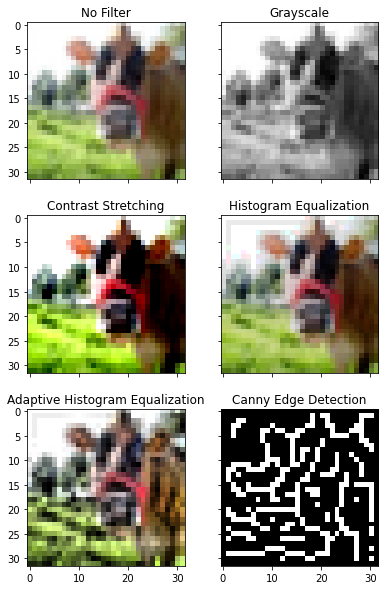

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

(x_train, y_train), (x_test, y_test) = import_data()

image = np.copy(x_train[0])
image_grayscale, _ = convert_to_grayscale(np.array([image]), np.array([image]))
image_grayscale = image_grayscale[0]
image_contrast = increase_image_contrast(image, 20)
image_hist = equalize_hist(image)
image_adapt = equalize_adapthist(image, 0.02)
image_canny, _ = canny_edge_filter_all(np.array([image]), np.array([image]))
image_canny = image_canny[0]

image_list = [image, image_grayscale, image_contrast, image_hist, image_adapt, image_canny]

fig = plt.figure(figsize=(15., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch. 
                 )

index = 0
for ax, im in zip(grid, image_list):
    label = ''
    if index == 0:
        label = "No Filter"
    elif index == 1:
        label = "Grayscale"
    elif index == 2:
        label = "Contrast Stretching"
    elif index == 3:
        label = "Histogram Equalization"
    elif index == 4:
        label = "Adaptive Histogram Equalization"
    elif index == 5:
        label = "Canny Edge Detection"
    ax.set_title(label)
    
    if index == 1 or index == 5:
        ax.imshow(im, cmap="gray")
    else:
        ax.imshow(im)
    index += 1

plt.show()

#### Random Forest

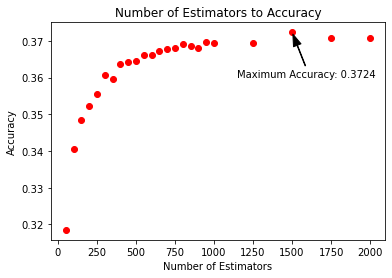

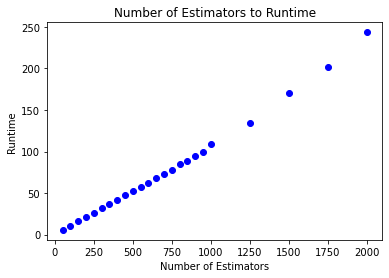

In [ ]:
with open('test_results/rf_estimators.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                'n_estimators' : int(row[0]),
                'max_features' : row[1],
                'criterion' : row[2],
                'bootstrap' : row[3],
                'accuracy' : float(row[4]),
                'runtime' : float(row[5])
            })
        line_count += 1
    
    n_estimators_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        n_estimators_list.append(result['n_estimators'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(n_estimators_list, accuracies, 'ro')
    
    plt.title('Number of Estimators to Accuracy')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.3724', xy=(1500, 0.37235), xytext=(1150, 0.36),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(n_estimators_list, runtimes, 'bo')
    
    plt.title('Number of Estimators to Runtime')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Runtime')
    plt.show()

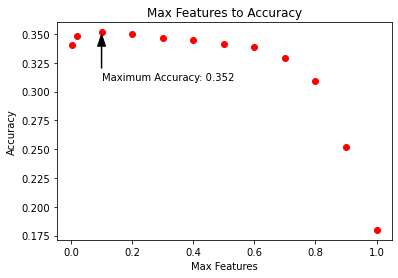

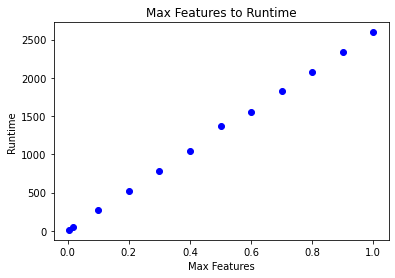

In [ ]:
with open('test_results/rf_features.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count > 2:
            results.append({
                'n_estimators' : int(row[0]),
                'max_features' : float(row[1]),
                'criterion' : row[2],
                'bootstrap' : row[3],
                'accuracy' : float(row[4]),
                'runtime' : float(row[5])
            })
        elif line_count > 0:
            features = 0
            if row[1] == 'sqrt':
                features = math.sqrt(32*32*3) / (32*32*3)
            elif row[1] == 'log2':
                features = math.log((32*32*3), 2) / (32*32*3)
            results.append({
                'n_estimators' : int(row[0]),
                'max_features' : features,
                'criterion' : row[2],
                'bootstrap' : row[3],
                'accuracy' : float(row[4]),
                'runtime' : float(row[5])
            })
                
        line_count += 1
    
    max_features_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        max_features_list.append(result['max_features'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(max_features_list, accuracies, 'ro')
    
    plt.title('Max Features to Accuracy')
    plt.xlabel('Max Features')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.352', xy=(0.1, 0.35154), xytext=(0.1, 0.31),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(max_features_list, runtimes, 'bo')
    
    plt.title('Max Features to Runtime')
    plt.xlabel('Max Features')
    plt.ylabel('Runtime')
    plt.show()

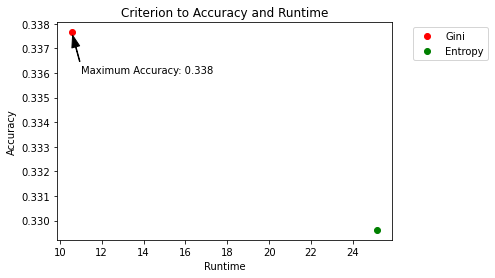

In [ ]:
with open('test_results/rf_criterion.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                'n_estimators' : int(row[0]),
                'max_features' : row[1],
                'criterion' : row[2],
                'bootstrap' : row[3],
                'accuracy' : float(row[4]),
                'runtime' : float(row[5])
            })
        line_count += 1
  
    gini_accuracy = []
    entropy_accuracy = []
    
    gini_runtime = []
    entropy_runtime = []
    
    for result in results:
        if result['criterion'] == 'gini':
            gini_accuracy.append(result['accuracy'])
            gini_runtime.append(result['runtime'])
        elif result['criterion'] == 'entropy':
            entropy_accuracy.append(result['accuracy'])
            entropy_runtime.append(result['runtime'])
            
    plt.plot(gini_runtime, gini_accuracy, 'ro', label="Gini")
    plt.plot(entropy_runtime, entropy_accuracy, 'go', label="Entropy")
    
    plt.title('Criterion to Accuracy and Runtime')
    plt.xlabel('Runtime')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.338', xy=(10.59134, 0.3376), xytext=(11, 0.336),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

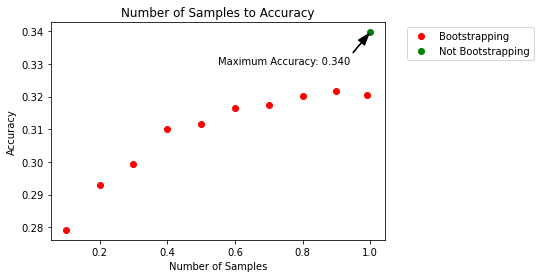

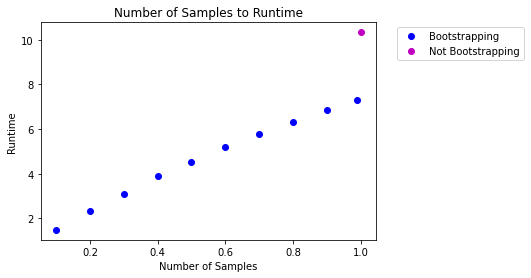

In [ ]:
with open('test_results/rf_bootstrap.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                'n_estimators' : int(row[0]),
                'max_features' : row[1],
                'criterion' : row[2],
                'bootstrap' : row[3],
                'max_samples' : float(row[4]),
                'accuracy' : float(row[5]),
                'runtime' : float(row[6])
            })
        line_count += 1
    
    bootstrap_false_sample = []
    bootstrap_samples = []
    
    bootstrap_false_accuracy = []
    accuracies = []
    
    bootstrap_false_runtime = []
    runtimes = []
    
    for result in results:
        if result['bootstrap'] == 'True':
            bootstrap_samples.append(result['max_samples'])
            accuracies.append(result['accuracy'])
            runtimes.append(result['runtime'])
        else:
            bootstrap_false_sample.append(result['max_samples'])
            bootstrap_false_accuracy.append(result['accuracy'])
            bootstrap_false_runtime.append(result['runtime'])
    
    plt.plot(bootstrap_samples, accuracies, 'ro', label='Bootstrapping')
    plt.plot(bootstrap_false_sample, bootstrap_false_accuracy, 'go', label='Not Bootstrapping')
    
    plt.title('Number of Samples to Accuracy')
    plt.xlabel('Number of Samples')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.annotate('Maximum Accuracy: 0.340', xy=(1, 0.33968), xytext=(0.55, 0.33),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(bootstrap_samples, runtimes, 'bo', label='Bootstrapping')
    plt.plot(bootstrap_false_sample, bootstrap_false_runtime, 'mo', label='Not Bootstrapping')
    
    plt.title('Number of Samples to Runtime')
    plt.xlabel('Number of Samples')
    plt.ylabel('Runtime')
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

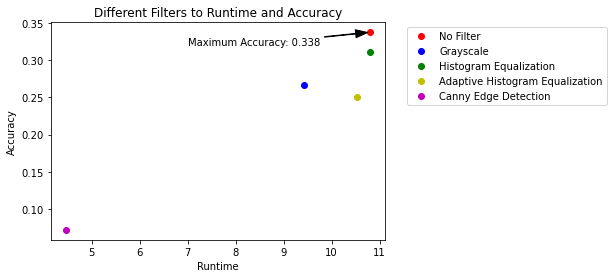

In [ ]:
with open('test_results/rf_filter.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                'n_estimators' : int(row[0]),
                'max_features' : row[1],
                'criterion' : row[2],
                'bootstrap' : row[3],
                'technique' : row[4],
                'accuracy' : float(row[5]),
                'runtime' : float(row[6])
            })
        line_count += 1
    
    none_accuracy = []
    none_runtime = []
    
    gray_accuracy = []
    gray_runtime = []
    
    hist_accuracy = []
    hist_runtime = []
    
    adapt_accuracy = []
    adapt_runtime = []
    
    canny_accuracy = []
    canny_runtime = []
    
    for result in results:
        if result['technique'] == 'none':
            none_accuracy.append(result['accuracy'])
            none_runtime.append(result['runtime'])
        elif result['technique'] == 'grayscale':
            gray_accuracy.append(result['accuracy'])
            gray_runtime.append(result['runtime'])
        elif result['technique'] == 'hist equalization':
            hist_accuracy.append(result['accuracy'])
            hist_runtime.append(result['runtime'])
        elif result['technique'] == 'adaptive equalization':
            adapt_accuracy.append(result['accuracy'])
            adapt_runtime.append(result['runtime'])
        elif result['technique'] == 'canny':
            canny_accuracy.append(result['accuracy'])
            canny_runtime.append(result['runtime'])
    
    plt.plot(none_runtime, none_accuracy, 'ro', label="No Filter")
    plt.plot(gray_runtime, gray_accuracy, 'bo', label="Grayscale")
    plt.plot(hist_runtime, hist_accuracy, 'go', label="Histogram Equalization")
    plt.plot(adapt_runtime, adapt_accuracy, 'yo', label="Adaptive Histogram Equalization")
    plt.plot(canny_runtime, canny_accuracy, 'mo', label="Canny Edge Detection")
    
    plt.title('Different Filters to Runtime and Accuracy')
    plt.xlabel('Runtime')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.338', xy=(10.80175, 0.3376), xytext=(7.0, 0.32),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

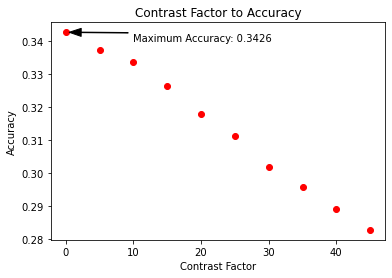

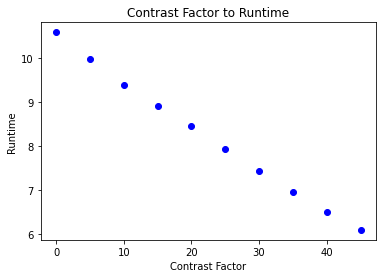

In [ ]:
with open('test_results/rf_contrast.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                'n_estimators' : int(row[0]),
                'max_features' : row[1],
                'criterion' : row[2],
                'bootstrap' : row[3],
                'contrast' : int(row[4]),
                'accuracy' : float(row[5]),
                'runtime' : float(row[6])
            })
        line_count += 1
    
    contrast_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        contrast_list.append(result['contrast'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(contrast_list, accuracies, 'ro')
    
    plt.title('Contrast Factor to Accuracy')
    plt.xlabel('Contrast Factor')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.3426', xy=(0, 0.3426), xytext=(10, 0.34),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(contrast_list, runtimes, 'bo')
    
    plt.title('Contrast Factor to Runtime')
    plt.xlabel('Contrast Factor')
    plt.ylabel('Runtime')
    plt.show()

#### Multi-Layer Perceptron

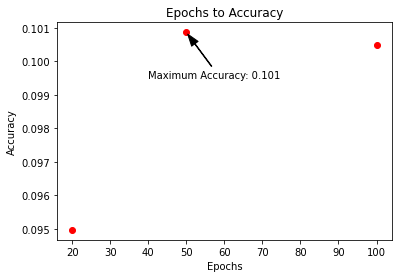

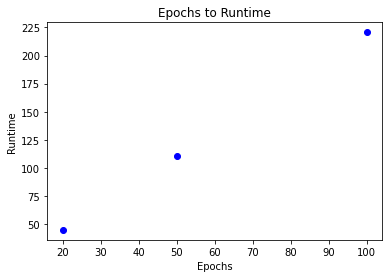

In [ ]:
with open('test_results/mlp_epochs.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    epochs_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        epochs_list.append(result['epochs'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(epochs_list, accuracies, 'ro')
    
    plt.title('Epochs to Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.101', xy=(50, 0.10087), xytext=(40, 0.0995),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(epochs_list, runtimes, 'bo')
    
    plt.title('Epochs to Runtime')
    plt.xlabel('Epochs')
    plt.ylabel('Runtime')
    plt.show()

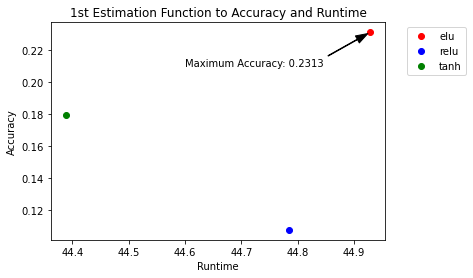

In [ ]:
with open('test_results/mlp_first_activation_function.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    func_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        func_list.append(result['1st est func'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot([runtimes[0]], [accuracies[0]], 'ro', label="elu")
    plt.plot([runtimes[1]], [accuracies[1]], 'bo', label="relu")
    plt.plot([runtimes[2]], [accuracies[2]], 'go', label="tanh")
    
    plt.title('1st Estimation Function to Accuracy and Runtime')
    plt.xlabel('Runtime')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.2313', xy=(runtimes[0], accuracies[0]), xytext=(44.6, 0.21),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

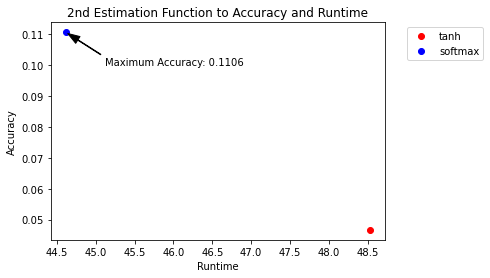

In [ ]:
with open('test_results/mlp_second_activation_function.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    func_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        func_list.append(result['2nd est func'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot([runtimes[0]], [accuracies[0]], 'ro', label="tanh")
    plt.plot([runtimes[1]], [accuracies[1]], 'bo', label="softmax")
    
    plt.title('2nd Estimation Function to Accuracy and Runtime')
    plt.xlabel('Runtime')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.1106', xy=(runtimes[1], 0.1106), xytext=(runtimes[1] + 0.5, 0.10),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

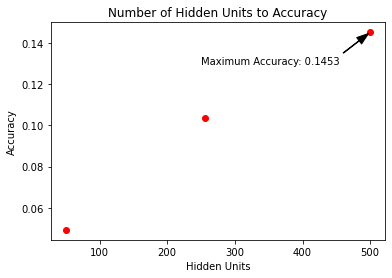

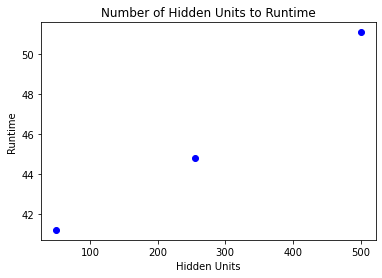

In [ ]:
with open('test_results/mlp_hidden_units.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    hidden_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        hidden_list.append(result['hidden units'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(hidden_list, accuracies, 'ro')
    
    plt.title('Number of Hidden Units to Accuracy')
    plt.xlabel('Hidden Units')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.1453', xy=(hidden_list[2], accuracies[2]), xytext=(250, 0.13),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(hidden_list, runtimes, 'bo')
    
    plt.title('Number of Hidden Units to Runtime')
    plt.xlabel('Hidden Units')
    plt.ylabel('Runtime')
    plt.show()

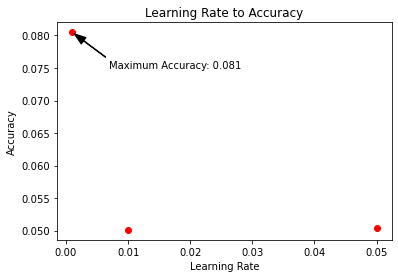

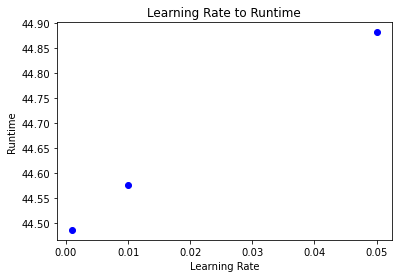

In [ ]:
with open('test_results/mlp_learning_rates.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    learning_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        learning_list.append(result['learning rate'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(learning_list, accuracies, 'ro')
    
    plt.title('Learning Rate to Accuracy')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.081', xy=(learning_list[2], accuracies[2]), xytext=(0.007, 0.075),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(learning_list, runtimes, 'bo')
    
    plt.title('Learning Rate to Runtime')
    plt.xlabel('Learning Rate')
    plt.ylabel('Runtime')
    plt.show()

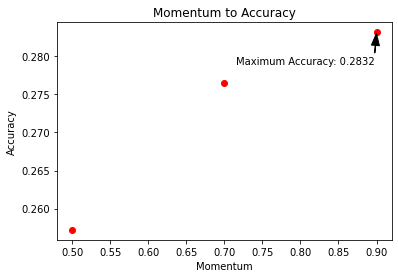

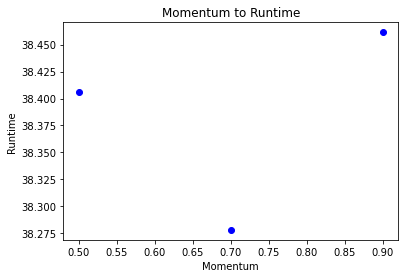

In [ ]:
with open('test_results/mlp_momentums.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    momentum_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        momentum_list.append(result['momentum'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot(momentum_list, accuracies, 'ro')
    
    plt.title('Momentum to Accuracy')
    plt.xlabel('Momentum')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.2832', xy=(momentum_list[2], accuracies[2]), xytext=(0.715, 0.279),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()
    
    plt.plot(momentum_list, runtimes, 'bo')
    
    plt.title('Momentum to Runtime')
    plt.xlabel('Momentum')
    plt.ylabel('Runtime')
    plt.show()

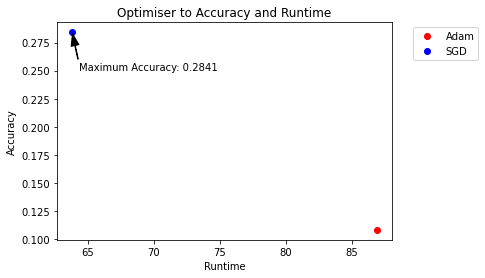

In [ ]:
with open('test_results/mlp_optimisers.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []
    for row in csv_reader:
        if line_count != 0:
            results.append({
                '1st est func' : row[0],
                '2nd est func' : row[1],
                'loss func' : row[2],
                'learning rate' : float(row[3]),
                'optimiser' : row[4],
                'momentum' : float(row[5]),
                'decay' : float(row[6]),
                'epochs' : int(row[7]),
                'hidden units' : int(row[8]),
                'accuracy' : float(row[9]),
                'runtime' : float(row[10])
            })
        line_count += 1
    
    opt_list = []
    accuracies = []
    runtimes = []
    
    for result in results:
        opt_list.append(result['optimiser'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])
    
    plt.plot([runtimes[0]], [accuracies[0]], 'ro', label="Adam")
    plt.plot([runtimes[1]], [accuracies[1]], 'bo', label="SGD")
    
    plt.title('Optimiser to Accuracy and Runtime')
    plt.xlabel('Runtime')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 0.2841', xy=(runtimes[1], accuracies[1]), xytext=(runtimes[1] + 0.5, 0.25),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

#### Support Vector Machine

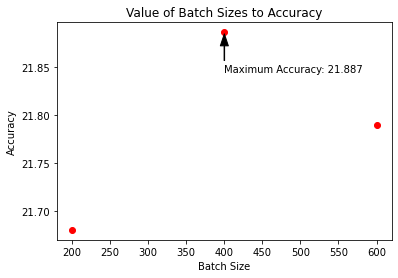

In [ ]:
with open('test_results/svm_batch_size.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []

    for row in csv_reader:
        if line_count != 0:
            results.append({
              'weights' : row[0],
              'learning_rate' : row[1],
              'reg_param' : row[2],
              'iterations' : row[3],
              'batch_size' : float(row[4]),
              'accuracy' : float(row[5]),
              'runtime' : float(row[6])
              })
        line_count += 1

    n_estimators_list = []
    accuracies = []
    runtimes = []

    for result in results:
        n_estimators_list.append(result['batch_size'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])

    plt.plot(n_estimators_list, accuracies, 'ro')

    plt.title('Value of Batch Sizes to Accuracy')
    plt.xlabel('Batch Size')
    plt.ylabel('Accuracy')
    plt.annotate('Maximum Accuracy: 21.887', xy=(n_estimators_list[1], accuracies[1]), xytext=(400, 21.845),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
    plt.show()

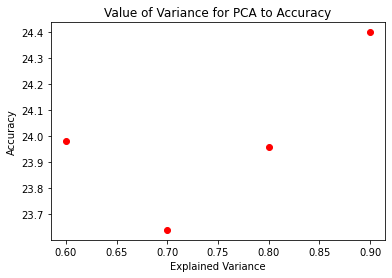

In [ ]:
with open('test_results/svm_pca.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []

    for row in csv_reader:
        if line_count != 0:
            results.append({
              'variance' : float(row[0]),
              'accuracy' : float(row[1]),
            })
        line_count += 1

    n_estimators_list = []
    accuracies = []

    variances= [0.6, 0.7, 0.8, 0.9] 

    for result in results:
        n_estimators_list.append(result['variance'])
        accuracies.append(result['accuracy'])

    plt.plot(n_estimators_list, accuracies, 'ro')

    plt.title('Value of Variance for PCA to Accuracy')
    plt.xlabel('Explained Variance')
    plt.ylabel('Accuracy')
    plt.show()

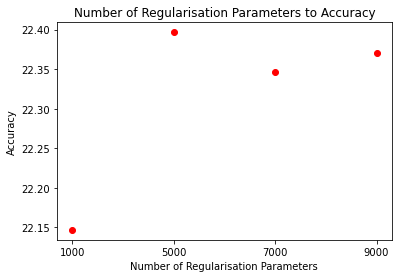

In [ ]:
with open('test_results/svm_reg_param.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []

    for row in csv_reader:
        if line_count != 0:
            results.append({
              'weights' : row[0],
              'learning_rate' : row[1],
              'reg_param' : row[2],
              'iterations' : row[3],
              'batch_size' : float(row[4]),
              'accuracy' : float(row[5]),
              'runtime' : float(row[6])
            })
        line_count += 1

    n_estimators_list = []
    accuracies = []
    runtimes = []

    for result in results:
        n_estimators_list.append(result['reg_param'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])

    plt.plot(n_estimators_list, accuracies, 'ro')

    plt.title('Number of Regularisation Parameters to Accuracy')
    plt.xlabel('Number of Regularisation Parameters')
    plt.ylabel('Accuracy')
    plt.show()

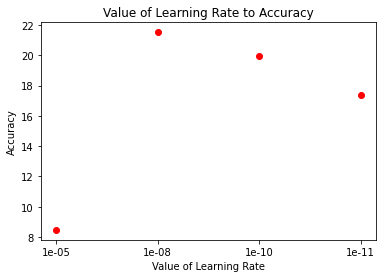

In [ ]:
with open('test_results/svm_learning_rates.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []

    for row in csv_reader:
        if line_count != 0:
            results.append({
              'weights' : row[0],
              'learning_rate' : row[1],
              'reg_param' : row[2],
              'iterations' : row[3],
              'batch_size' : float(row[4]),
              'accuracy' : float(row[5]),
              'runtime' : float(row[6])
              })
        line_count += 1

    n_estimators_list = []
    accuracies = []
    runtimes = []

    for result in results:
        n_estimators_list.append(result['learning_rate'])
        accuracies.append(result['accuracy'])
        runtimes.append(result['runtime'])

    plt.plot(n_estimators_list, accuracies, 'ro')

    plt.title('Value of Learning Rate to Accuracy')
    plt.xlabel('Value of Learning Rate')
    plt.ylabel('Accuracy')
    plt.show()

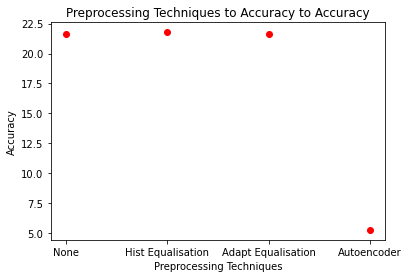

In [ ]:
with open('test_results/svm_preprocessing.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    results = []

    for row in csv_reader:
        if line_count != 0:
            results.append({
              'technique' : row[0],
              'accuracy' : float(row[1]),
            })
        line_count += 1

    n_estimators_list = []
    accuracies = []
    runtimes = []

    for result in results:
        n_estimators_list.append(result['technique'])
        accuracies.append(result['accuracy'])

    plt.plot(n_estimators_list, accuracies, 'ro')

    plt.title('Preprocessing Techniques to Accuracy to Accuracy')
    plt.xlabel('Preprocessing Techniques')
    plt.ylabel('Accuracy')
    plt.show()